In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_path = '/content/drive/MyDrive/Garbage classification/'

datagen = ImageDataGenerator(rescale=1./255)
data_gen = datagen.flow_from_directory(image_path, target_size=(150, 150), batch_size=32)


Found 8627 images belonging to 6 classes.


# Data Preprocessing

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import  layers

In [5]:
dataset_main_path = "/content/drive/MyDrive/Garbage classification"
CONFIG = {
    "IM_SIZE" : 224,
    "BATCH_SIZE" : 32,
}

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_main_path,
    image_size = (CONFIG['IM_SIZE'],CONFIG['IM_SIZE']),
    batch_size = CONFIG['BATCH_SIZE'],
    seed = 123,
    subset = "training",
    validation_split = 0.2,
    shuffle = True
)

Found 8627 files belonging to 6 classes.
Using 6902 files for training.


In [7]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_main_path,
    image_size = (CONFIG['IM_SIZE'],CONFIG['IM_SIZE']),
    batch_size = CONFIG['BATCH_SIZE'],
    seed = 123,
    subset = "validation",
    validation_split = 0.2,
)

Found 8627 files belonging to 6 classes.
Using 1725 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


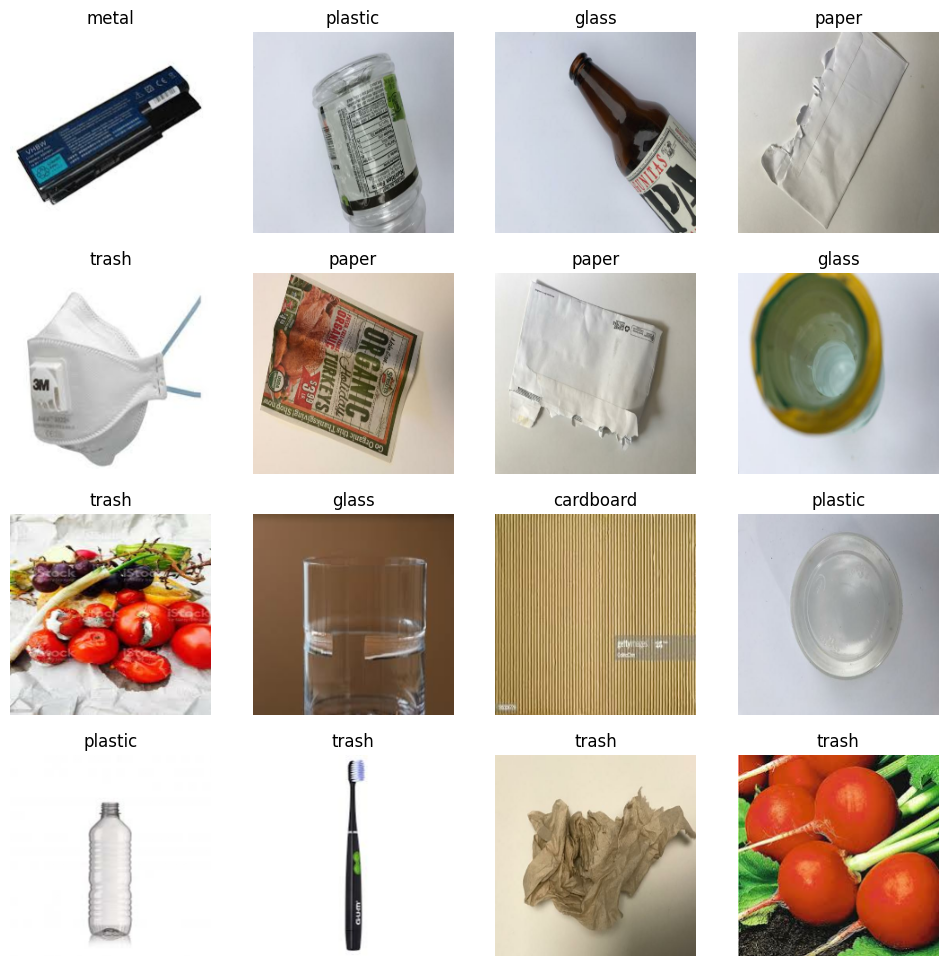

In [9]:
plt.figure(figsize=(12,12))

for images, labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    class_train_name = class_names[labels[i].numpy()]
    plt.title(class_train_name)
    plt.axis("off")

# Data Augmentation

In [10]:
data_augmentation_layers = Sequential([
    layers.RandomFlip("horizantal",input_shape=(CONFIG['IM_SIZE'],CONFIG['IM_SIZE'],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


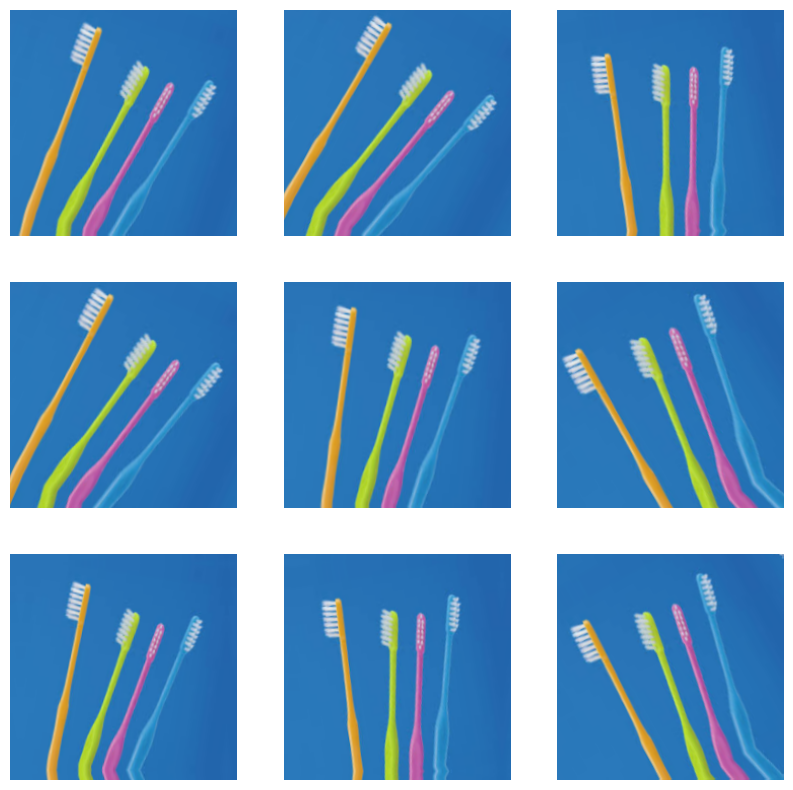

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layers(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
print(f"Train Size {len(train_ds)} Val Size {len(val_ds)}")
print(train_ds)
print(val_ds)

Train Size 216 Val Size 216
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# CNN Scratch

In [14]:
model = Sequential([
    layers.Rescaling(1./255, input_shape = (CONFIG['IM_SIZE'],CONFIG['IM_SIZE'],3)),

    data_augmentation_layers,

    layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),

    layers.Dense(512,activation='relu'),
    layers.Dense(128,activation='relu'),

    layers.Dense(len(class_names),activation='softmax')

])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,462,534 (169.61 MB)

 Trainable params: 44,462,534 (169.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [16]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    batch_size = CONFIG['BATCH_SIZE'],
)

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2152s 7s/step - accuracy: 0.3775 - loss: 1.5915 - val_accuracy: 0.5394 - val_loss: 1.2213
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1402s 6s/step - accuracy: 0.5718 - loss: 1.0980 - val_accuracy: 0.6881 - val_loss: 0.8755
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1409s 6s/step - accuracy: 0.6726 - loss: 0.8866 - val_accuracy: 0.6988 - val_loss: 0.8495
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1406s 6s/step - accuracy: 0.7147 - loss: 0.7726 - val_accuracy: 0.7386 - val_loss: 0.6984
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1386s 6s/step - accuracy: 0.7475 - loss: 0.6970 - val_accuracy: 0.7549 - val_loss: 0.6687
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1408s 6s/step - accuracy: 0.7859 - loss: 0.5858 - val_accuracy: 0.8321 - val_loss: 0.4810
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1446s 6s/step - accuracy: 0.8119 - loss: 0.5285 - val_accuracy: 0.8167 - val_loss: 0.5223
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1408s 6s/step - accuracy: 0.8348 - loss: 0.4774 - 

# Model Evaluate

In [17]:
loss, acc = model.evaluate(val_ds,verbose = 1)
print(f"Loss {loss}")
print(f"Acc {round((acc * 100),2)}")

216/216 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.9681 - loss: 0.0927
Loss 0.09766609221696854
Acc 96.57


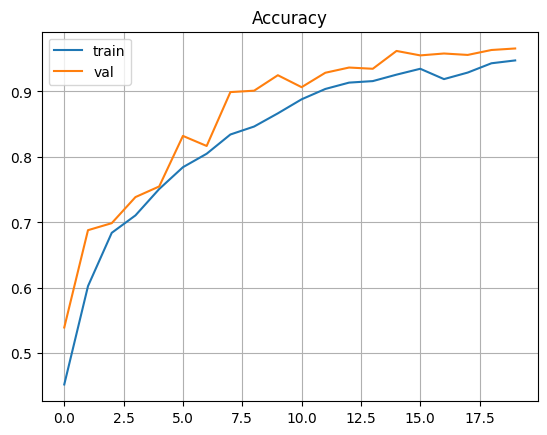

In [18]:
plt.title("Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.legend(['train','val'])
plt.show()

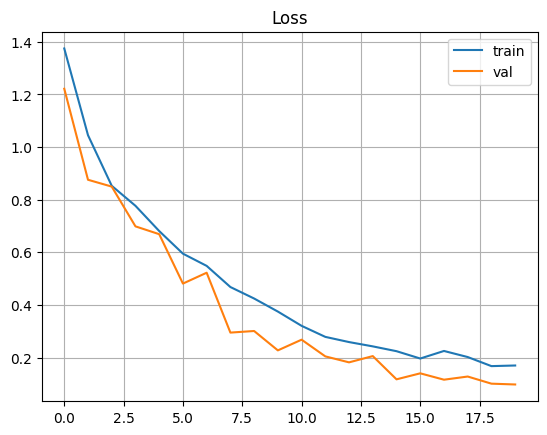

In [19]:
plt.title("Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.legend(['train','val'])
plt.show()

# Predict Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


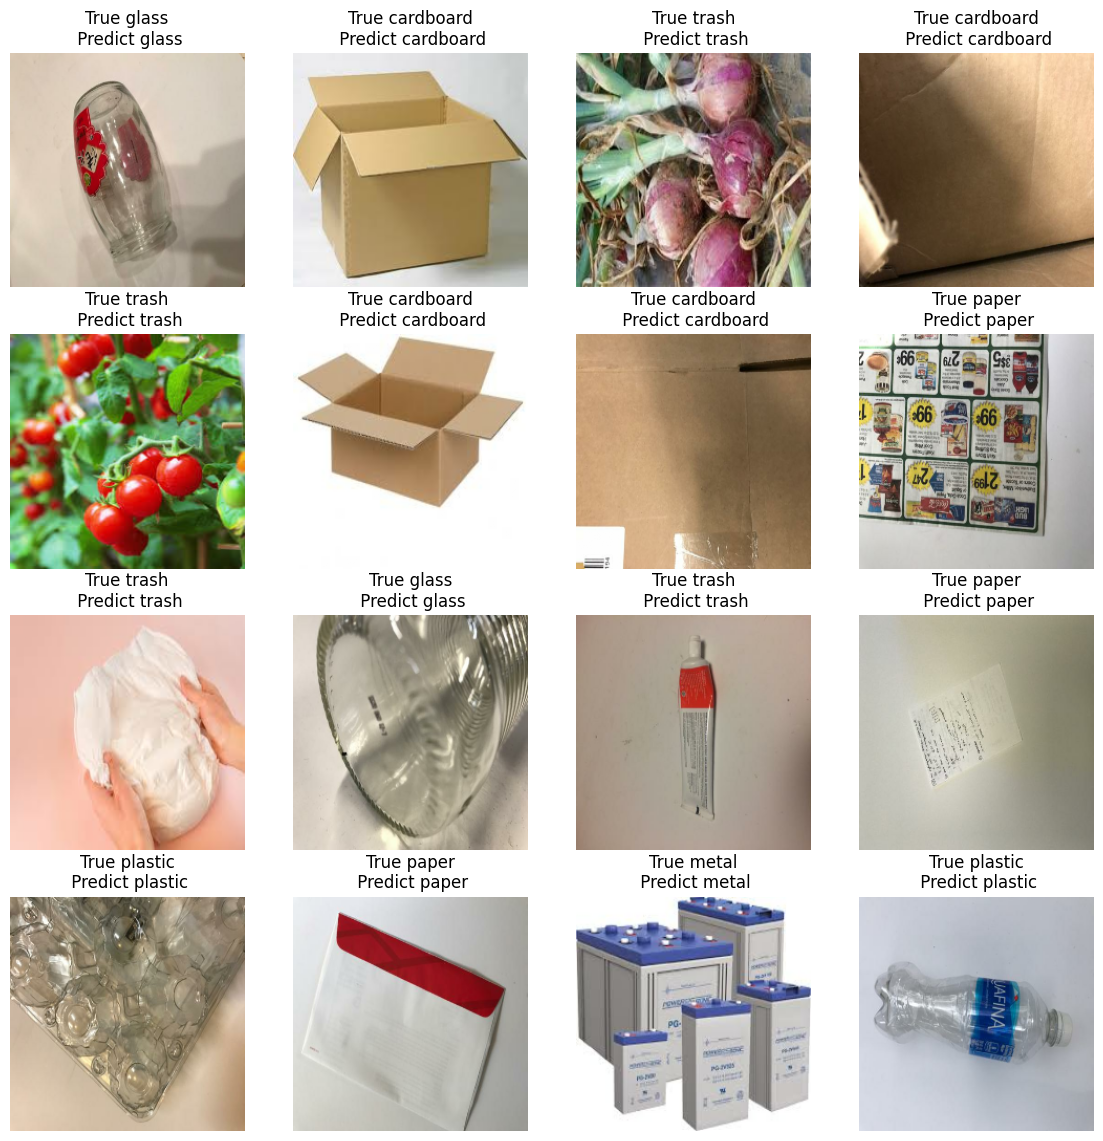

In [20]:
plt.figure(figsize=(14,14))

for images, labels in val_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i + 1)
    true_label = class_names[labels[i].numpy()]
    img_pred = tf.expand_dims(images[i],axis = 0)
    predict_label = class_names[np.argmax(model.predict(img_pred))]
    plt.title(f"True {true_label}\n Predict {predict_label}")
    plt.imshow(images[i]/255)
    plt.axis('off')

In [29]:
model.save("/content/drive/MyDrive/Garbage classification/model_two.h5")


In [28]:
model.save("model_two.h5")